# Ukázka práce adaptivního prahování

Prahování je základní metodou segmentace. Využití prahování můžeme najít v [dokumentaci knihovny OpenCV](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html).

Cílem ukázky je ukázat práci algoritmu pro adaptivní prahování pomocí Gaussova jádra.

![](thresholding.jpg)

---

## Načtení pomocných funkcí

In [1]:
%run ../../files/svz.ipynb

## Tvorba Gaussova jádra

Ukázka tvorby 2D Gaussova jádra pomocí vzorce pro výpočet Gaussovy funkce ([viz dokumentace](https://docs.opencv.org/2.4/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter)).

$$G_0(x,y) = A \cdot e^{\frac{-\left(x-\mu_x\right)^2}{2\sigma^2_x} + \frac{-\left(y-\mu_y\right)^2}{2\sigma^2_y}}$$

Výpočet defaultního $\sigma$ ze zvolené _velikosti_ gaussova jádra se spočítá pomocí vzorce ([viz dokumentace](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa)). Lze nastavit i manuálně.

$$\sigma = 0,3 \cdot ((velikost - 1) \cdot 0,5 - 1) + 0.8$$

In [2]:
ims_gauss = []
titles = []

# Pro velikosti gaussova jádra 3, 5, 7, 9, 11, 13
for i in range(3, 15, 2):
    
    # Výpočet defaultní sigmy
    sigma_def = 0.3 * ((i - 1) * 0.5 - 1) + 0.8
    
    # Tvorba gaussova jádra jako maticový součin gaussovy funkce
    gauss = cv2.getGaussianKernel(i, sigma_def)
    g_xy = gauss * cv2.transpose(gauss)
    
    ims_gauss.append(g_xy)
    
    # Název za účelem vizualizace
    title = 'Size: ' + str(i) + '×' + str(i) + ', sigma = ' + str(sigma_def)
    titles.append(title)

[[0.057 0.125 0.057]
 [0.125 0.272 0.125]
 [0.057 0.125 0.057]]


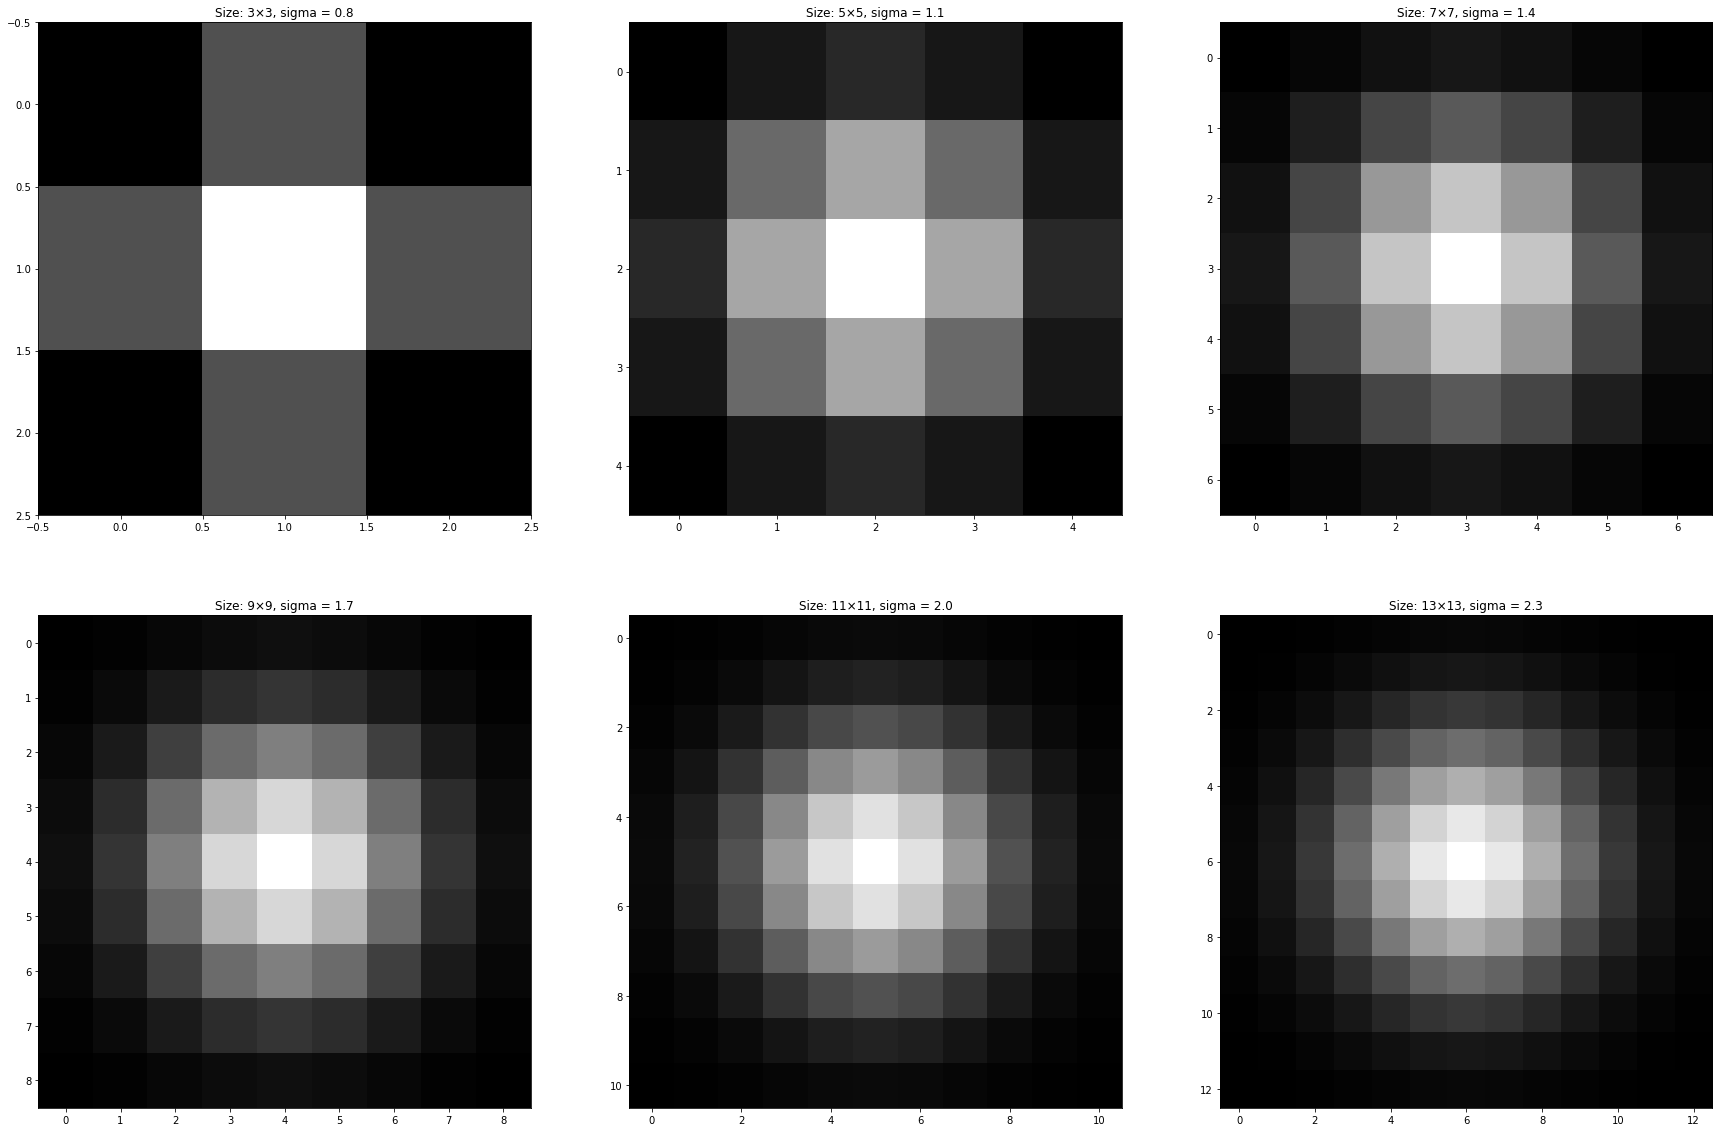

In [3]:
# Ukázka vytvořených gaussových jader
# ... zobrazení je normalizované pouze za účelem vizualizace, ve skutečnosti se jedná o desetinná čísla
print(ims_gauss[0])
plot_images(*ims_gauss, titles=titles, normalize=True)

## Ukázka na obrázku z příkladu z dokumentace OpenCV

Pro demonstraci je vybráno gaussovo jádro o velikosti 9×9 pixelů.

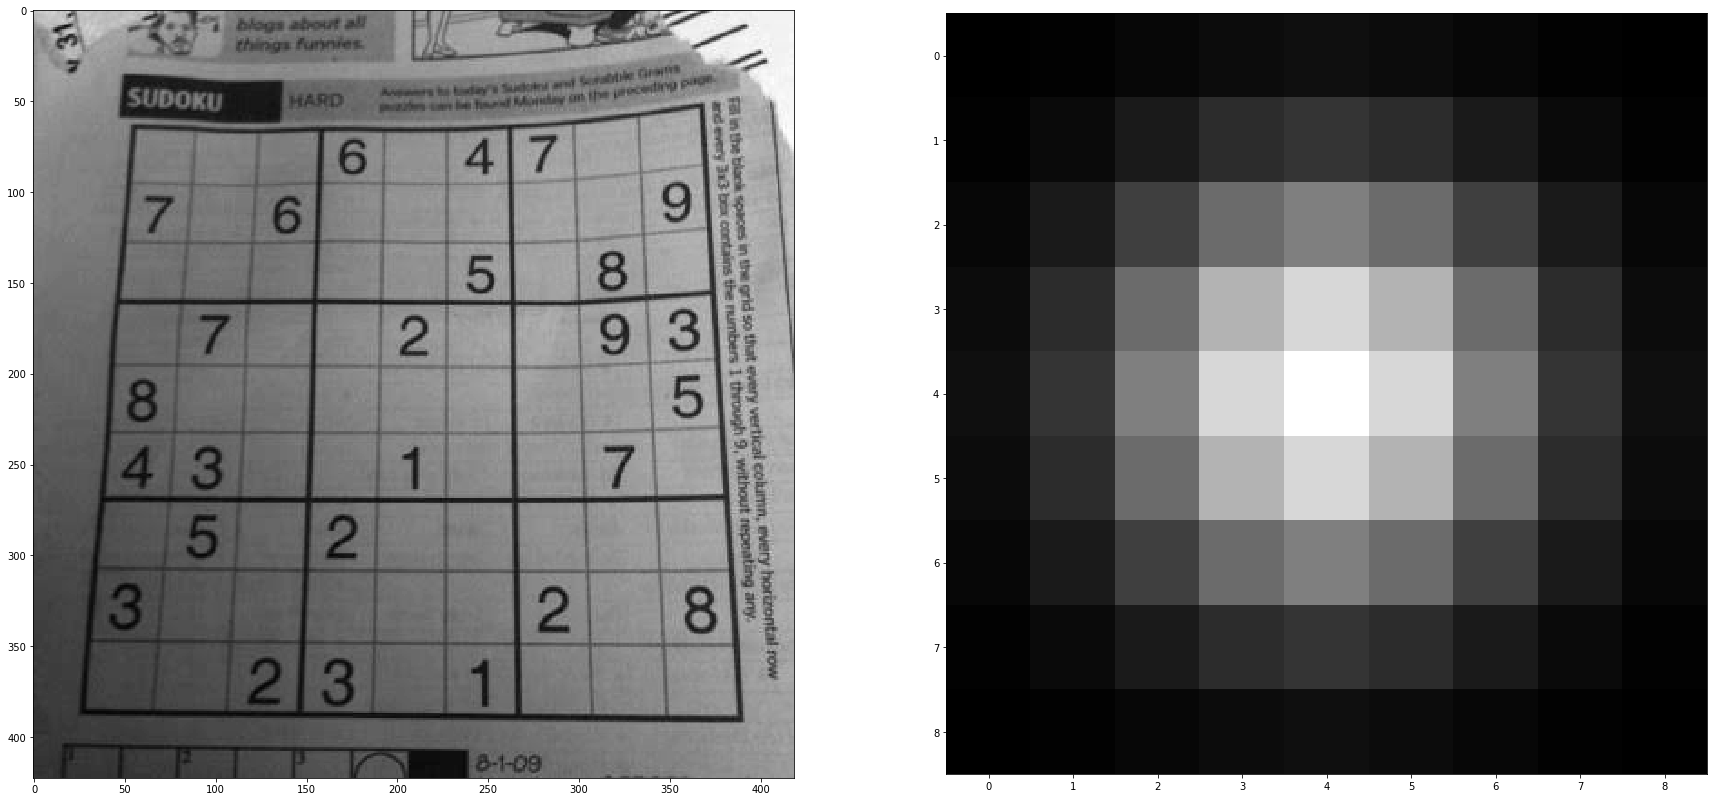

In [4]:
# Obrázek je načten jako šedotónový
image = to_gray(load_image('./sudoku.jpg'))
gauss_9x9 = ims_gauss[3]

# Ukázka vstupního obrázku a použitého gaussova jádra
# ... zobrazení je normalizované pouze za účelem vizualizace, ve skutečnosti se jedná o desetinná čísla
plot_images(image, gauss_9x9, normalize=True)

## Řešení okrajových podmínek

In [5]:
# Pomocná funkce pro řešení okrajových podmínek při výběru podobrázků
def crop_bound(v, max_v):
    if v < 0:
        return 0
    elif v > max_v:
        return max_v
    else:
        return v
    
# Pomocná funkce pro řešení správného středu výsledku (anchor) 
def get_anchor(pos, image_center, image_part_size, gauss_size, gauss_center):
    if image_part_size < gauss_size and pos < image_center:
        return image_part_size - gauss_center
    else:
        return gauss_center

## Algoritmus výpočtu adaptivního prahu

Hodnota prahu `thresh` pro (x,y) je váženým součtem (cross-korelace s Gaussovým jádrem) velikosti podobrázku o stejné velikosti jako Gaussovo jádro (`h_gauss` × `w_gauss`) v okolí bodu (x,y) s odečtením konstanty `const_C` ([viz překlad dokumentace](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=ADAPTIVE_THRESH_GAUSSIAN_C#adaptivethreshold)).

Algoritmus tedy vždy vyřízne podobrázek hlavního obrazu (matici o stejné velikosti jako je velikost zvoleného Gaussova jádra). Následně provede cross-korelaci matice s jádrem pomocí funkce [filter2D()](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04).

Funkce `filter2D()` pracuje podle vzorce, kde $*$ označuje konvoluci, _jádro_ je Gaussovo jádro a _matice_ je vyřízlý podobrázek:

$$vysledek(x,y) = \sum\limits_{
\begin{array}{}
0 \leq x' \leq h\_gauss, \\
0 \leq y' \leq w\_gauss
\end{array}
}
jadro(x', y') * matice(x + x' - h\_gauss\_c, y + y' - w\_gauss\_c)
$$

Proměnné `h_gauss`, `w_gauss` jsou velikosti Gaussova jádra a `h_gauss_c` a `w_gauss_c` jsou souřadnice středu Gaussova jádra (neboli polovina jeho velikosti).

Výsledkem aplikace funkce `filter2D()` je obrázek, který má všechny svoje hodnoty upraveny (rozmazány Gaussovým jádrem). Hodnota prahu `thresh` je pak podle vzorce hodnota ve středu výsledku (resp. v takovém místě, které je označené jako `anchor` - [viz řešení okrajových podmínek obrazu](#Řešení-okrajových-podmínek)).

In [6]:
# Zisk velikosti matice pro výběr podobrázku (a jejího středu)
h_gauss, w_gauss = gauss_9x9.shape
h_gauss_c = int(math.floor(h_gauss / 2))
w_gauss_c = int(math.floor(w_gauss / 2))

# Velikost obrázku pro jednotlivé cykly a okrajové podmínky
im_h, im_w = image.shape
im_h_c = int(math.floor(im_h / 2))
im_w_c = int(math.floor(im_w / 2))
max_x = im_h
max_y = im_w

# Konstanta upravující hodnotu pro prahování
const_C = 1

# Výsledný binární obrázek
image_adapt_man = np.zeros_like(image)

# Přes celý obrázek
for x in range(0, max_x):
    for y in range(0, max_y):
        
        # Aktuální hodnota pozice v obraze
        pos = (x, y)
        
        # Výřez matice (podobrázku)
        image_part = image[
            crop_bound(pos[0] - h_gauss_c, max_x) : crop_bound(pos[0] + h_gauss_c, max_x),
            crop_bound(pos[1] - w_gauss_c, max_y) : crop_bound(pos[1] + w_gauss_c, max_y)
        ]
        # Aktuální velikost matice
        # ... mění se při výřezech kolem okrajů obrázku
        im_p_h, im_p_w = image_part.shape
        
        # Souřadnice středového pixelu matice při konvoluci
        # ... na okrajích obrázku je třeba brát v úvahu, že až polovina jádra leží mimo obrázek
        # ... tedy správné souřadnice nejsou ve středu matice, nýbrž blíže k okraji podle vzdálenosti
        anchor_x = get_anchor(pos[0], im_h_c, im_p_h, h_gauss, h_gauss_c)
        anchor_y = get_anchor(pos[1], im_w_c, im_p_w, w_gauss, w_gauss_c)
        anchor = (anchor_x, anchor_y)
        
        # Původní hodnota z obrazu pro porovnávání
        value = image_part[anchor]

        # Výsledek po cross-korelaci matice s jádrem
        # ... cv2.CV_8U volí přesnost metody (8 bit uint)
        # ... další možnosti jsou 16 bit uint, 32 bit float nebo 64 bit float
        image_part_man = cv2.filter2D(image_part, cv2.CV_8U, gauss_9x9)
        
        # Hodnota prahu z obrazu výsledku v bodě anchor
        # ... hodnotu prahu lze upravit pomocí konstanty
        thresh = image_part_man[anchor] - const_C
        
        # Hodnocení, zda je pixel popředí (objekt) nebo pozadí
        ob = value > thresh
        
        # Zápis hodnoty pixelu do výsledného binárního obrázku
        # ... výsledek segmentace
        image_adapt_man[x, y] = 255 if ob else 0 

## Vizualizace výsledků

Vizualizace ukazuje rozdíl mezi manuální metodou a metodou již hotovou v OpenCV. Rozdíl může být dán přesností s jakou se počítá cross-korelace popř. jinou chybou :).

Rozdíl metod: 1.154 %.


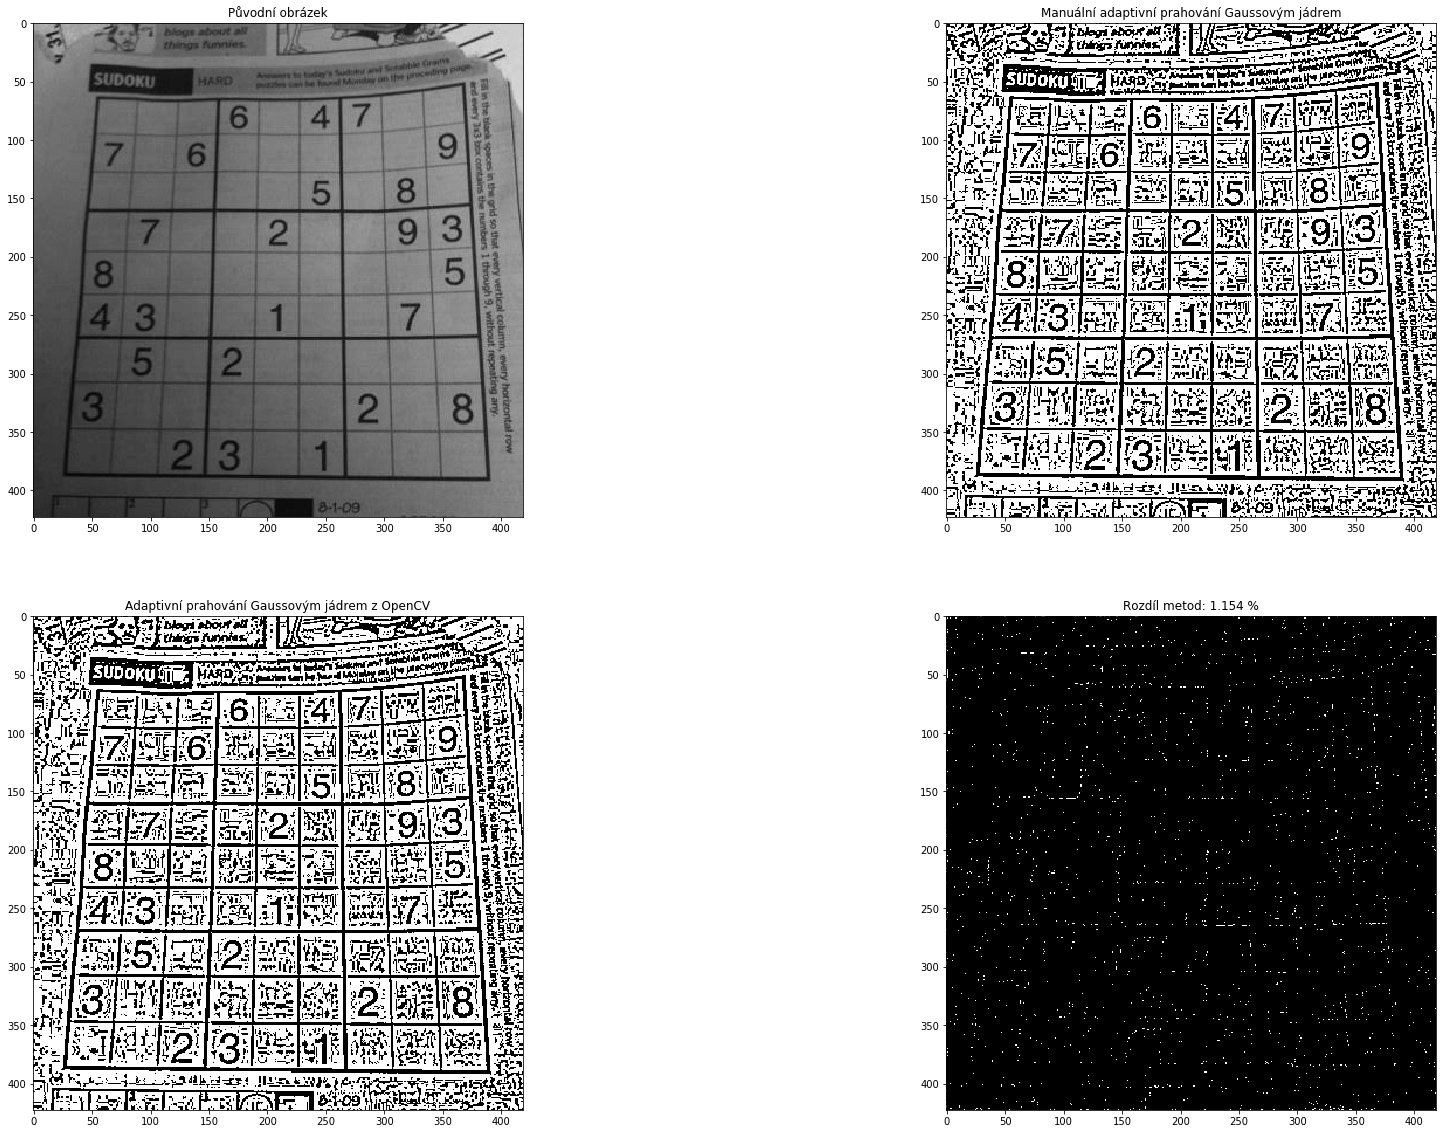

In [7]:
# Adaptivní segmentace pomocí již hotové metody z OpenCV
# ... konstanta const_C je využita stejná jako v kódu výše
image_adapt_auto = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, h_gauss, const_C)

# Vizuální zobrazení rozdílu obou metod
diff1 = image_adapt_auto - image_adapt_man
diff2 = image_adapt_man - image_adapt_auto
diff = cv2.bitwise_or(diff1, diff2)

# Početní zobrazení rozdílu obou metod
ratio = cv2.countNonZero(diff)/(im_h * im_w)
ratio_s = str(round(ratio * 100, 3)) + ' %'
print('Rozdíl metod: ' + ratio_s + '.')

# Konečná vizualizace výsledků
titles = ['Původní obrázek', 'Manuální adaptivní prahování Gaussovým jádrem', 'Adaptivní prahování Gaussovým jádrem z OpenCV', 'Rozdíl metod: ' + ratio_s]
plot_images(image, image_adapt_man, image_adapt_auto, diff, titles=titles)